# Credit Card Customers

In this project, we will use data from a credit card company to build a binary classifier which predicts which customers will churn. The data can be obtained from [this dataset](https://www.kaggle.com/sakshigoyal7/credit-card-customers) on Kaggle. 

The author of the dataset gives an important note: if our model predicts non-churning customers as churning, it won't hurt the business. However, we do not want to make the opposite error of predicting churning customers as non-churning. So, we should allow our model to be *sensitive* at the price of being less precise. Thus we will measure the effectiveness of our model by measuring its **Recall**: 
$$ \mathrm{Recall} = \frac{\mathrm{TP}}{\mathrm{TP}+\mathrm{FN}}$$ 
where $\mathrm{TP}$ and $\mathrm{FN}$ denote the number of *true positives* and *false negatives* our model predicts on the validation set, assuming that "churning" is our positive class.  

The author was able to build a model that achieved 62% recall. The task is to build a model which improves this number. 

## Data Loading and Exploratory Analysis

The previous owner of the data makes a note that we should ignore or delete the last two columns of the data.

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('BankChurners.csv').iloc[:,:-2]
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

### Feature Descriptions

The `CLIENTNUM` column can probably be ignored since we can identify customers based on their row in the dataframe. The `Attrition_Flag` column provides the labels we will use for our supervised-learning task. There are 19 other columns which we are free to use as training data. 

* `Customer_Age`: Demographic variable - Customer's Age in Years.
* `Gender`: Demographic variable - M=Male, F=Female.
* `Dependent_count`: Demographic variable - Number of dependents
* `Education_Level`: Demographic variable - Educational Qualification of the account holder (example: high school, college graduate, etc.)
* `Marital_Status`: Demographic variable - Married, Single, Divorced, Unknown.
* `Income_Category`: Demographic variable - Annual Income Category of the account holder (< \$40K, \$40K - 60K, \$60K - \$80K, \$80K-\$120K, > \$120k)
* `Card_Category`: Product Variable - Type of Card (Blue, Silver, Gold, Platinum)
* `Months_on_book`: Period of relationship with bank.
* `Total_Relationship_Count`: Total number of products held by the customer.
* `Months_Inactive_12_mon`: Number of months inactive in the last 12 months.
* `Contacts_Counts_12_mon`: Number of contacts in the last 12 months.
* `Credit_Limit`: Credit limit on the credit card.
* `Total_Revolving_Bal`: Total revolving balance on the credit card (the portion of credit card spending that goes unpaid at the end of a billing cycle).
* `Avg_Open_To_Buy`: Open to buy credit line (Average of last 12 months). The difference between the credit limit assigned to a cardholder account and the present balance on the account.
* `Total_Amt_Chng_Q4_Q1`: Change in transaction amount (Q4 over Q1).
* `Total_Trans_Amt`: Total transaction amount (last 12 months).
* `Total_trans_Ct`: Number of transactions (last 12 months).
* `Total_Ct_Chng_Q4_Q1`: Change in transaction count (Q4 over Q1).
* `Avg_Utilization_Ratio`: Average percentage of credit used with respect to the credit limit.

We have 10,127 entries to work with, which should be plenty to get a good model.

In [4]:
df.drop(columns=['CLIENTNUM'], inplace=True)

# 'Attrited Customer' is the positive class
df['Attrition_Flag'].replace({'Existing Customer' : 0, 'Attrited Customer' : 1}, inplace=True)

In [5]:
# Customer churn is ~16%. 
df['Attrition_Flag'].value_counts(normalize=True)

0    0.83934
1    0.16066
Name: Attrition_Flag, dtype: float64

In [29]:
# Split data into training and testing sets. 
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

train_y = train_df['Attrition_Flag']
test_y = test_df['Attrition_Flag']

train_X = train_df.drop(columns=['Attrition_Flag'])
test_X = test_df.drop(columns=['Attrition_Flag'])

train_X.iloc[0:20, :]

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,54,F,1,Unknown,Single,Unknown,Blue,36,1,3,3,3723.0,1728,1995.0,0.595,8554,99,0.678,0.464
1,58,F,4,High School,Married,Unknown,Blue,48,1,4,3,5396.0,1803,3593.0,0.493,2107,39,0.393,0.334
2,45,F,4,Unknown,Single,Less than $40K,Gold,36,6,1,3,15987.0,1648,14339.0,0.732,1436,36,1.250,0.103
3,34,F,2,Graduate,Single,Less than $40K,Blue,36,4,3,4,3625.0,2517,1108.0,1.158,2616,46,1.300,0.694
4,49,F,2,High School,Married,$40K - $60K,Blue,39,5,3,4,2720.0,1926,794.0,0.602,3806,61,0.794,0.708
5,60,F,0,Doctorate,Married,Less than $40K,Blue,45,5,2,4,1438.3,648,790.3,0.477,1267,27,1.077,0.451
6,43,F,4,Unknown,Single,Unknown,Blue,28,2,2,1,2838.0,1934,904.0,0.873,8644,87,0.554,0.681
7,52,F,2,Unknown,Single,$40K - $60K,Blue,45,3,1,3,3476.0,1560,1916.0,0.894,3496,58,0.871,0.449
8,30,M,0,Graduate,Married,Less than $40K,Blue,36,3,3,2,2550.0,1623,927.0,0.650,1870,51,0.275,0.636
9,33,F,3,Graduate,Single,Less than $40K,Blue,36,5,2,3,1457.0,0,1457.0,0.677,2200,45,0.364,0.000


Some of the features of integer types attain a wide range of values. We need to decide whether these features should be left as is, binned, or converted into floats and treated as continuous. 

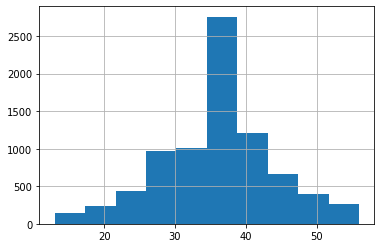

In [34]:
train_X['Months_on_book'].hist()

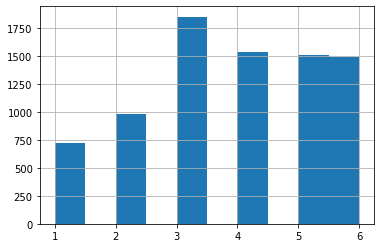

In [35]:
train_X['Total_Relationship_Count'].hist()

In [ ]:
cts_cols = ['Months_on_book', ]

### Encoding categorical variables

Our data enjoys five different features whose values are represented as strings. We should encode these into numeric data before moving on.

In [7]:
from pandas.api.types import is_object_dtype

obj_cols = [c for c in train_X.columns if is_object_dtype(train_X[c])]
obj_cols

['Gender',
 'Education_Level',
 'Marital_Status',
 'Income_Category',
 'Card_Category']

### Gender

In [8]:
train_X['Gender'].value_counts()

F    4279
M    3822
Name: Gender, dtype: int64

Unfortunately, the data only has two gender values. It is possible that customers of non-binary gender have significantly different attrition rates, but instead we will have to work within the very coarse framework given to us.

We will encode this as a binary variable.

In [9]:
gender_dict = {'F' : 0, 
               'M' : 1}
               
train_X['Gender'].replace(gender_dict, inplace=True)
test_X['Gender'].replace(gender_dict, inplace=True)

train_X['Gender'].value_counts()


0    4279
1    3822
Name: Gender, dtype: int64

### Education Level

In [10]:
train_X['Education_Level'].value_counts(normalize=True)

Graduate         0.312060
High School      0.199852
Unknown          0.148747
Uneducated       0.144550
College          0.100728
Post-Graduate    0.050241
Doctorate        0.043822
Name: Education_Level, dtype: float64

The values are partially-ordered since education levels follow a linear path, except that we have an `'Unknown'` value. We do not know why certain entries are labeled this way. We will assume it's because the customers chose not to provide this information, in which case this may be a useful category to keep. In any case, ~15% of entries are labeled `'Unknown'`, so we should not get rid of them.

We will use integer encoding with the assignment that `'Unknown'` is `0`.

In [11]:
education_dict = {'Unknown' : 0,
                  'Uneducated' : 1,
                  'High School' : 2,
                  'College' : 3,
                  'Graduate' : 4,
                  'Post-Graduate' : 5,
                  'Doctorate' :6}

train_X['Education_Level'].replace(education_dict, inplace=True)
test_X['Education_Level'].replace(education_dict, inplace=True)

train_X['Education_Level'].value_counts(normalize=True)

4    0.312060
2    0.199852
0    0.148747
1    0.144550
3    0.100728
5    0.050241
6    0.043822
Name: Education_Level, dtype: float64

### Marital Status

In [12]:
train_X['Marital_Status'].value_counts(normalize=True)

Married     0.465004
Single      0.388100
Divorced    0.075423
Unknown     0.071473
Name: Marital_Status, dtype: float64

There is no linear ordering on these values. We will use one hot encoding.

In [13]:
dummies = pd.get_dummies(train_X['Marital_Status'])
train_X = pd.concat([train_X, dummies], axis='columns')
train_X.drop(columns=['Unknown', 'Marital_Status'], inplace=True)    # Drop 'Unknown' to remove co-linearity of features. 

dummies = pd.get_dummies(test_X['Marital_Status'])
test_X = pd.concat([test_X, dummies], axis='columns')
test_X.drop(columns=['Unknown', 'Marital_Status'], inplace=True)    # Drop 'Unknown' to remove co-linearity of features. 

train_X.iloc[:5, -3:]

,Divorced,Married,Single
0,0,0,1
1,0,1,0
2,0,0,1
3,0,0,1
4,0,1,0


### Income Category

In [14]:
train_X['Income_Category'].value_counts(normalize=True)

Less than $40K    0.347118
$40K - $60K       0.179361
$80K - $120K      0.152697
$60K - $80K       0.138501
Unknown           0.109740
$120K +           0.072584
Name: Income_Category, dtype: float64

We can see our data is partially ordered with an `'Unknown'` value. Let's encode it in a similar way to how we encoded Education Level.

In [15]:
income_dict = {'Unknown' : 0,
               'Less than $40K' : 1,
               '$40K - $60K' : 2,
               '$60K - $80K' : 3,
               '$80K - $120K' : 4,
               '$120K +' : 5}

train_X['Income_Category'].replace(income_dict, inplace=True)
test_X['Income_Category'].replace(income_dict, inplace=True)

train_X['Income_Category'].value_counts(normalize=True)

1    0.347118
2    0.179361
4    0.152697
3    0.138501
0    0.109740
5    0.072584
Name: Income_Category, dtype: float64

### Card Category

In [16]:
train_X['Card_Category'].value_counts(normalize=True)

Blue        0.932848
Silver      0.053821
Gold        0.011480
Platinum    0.001852
Name: Card_Category, dtype: float64

The author of the dataset did not disclose any more information about what these values mean. I will make the assumption that the ordering
$$\textrm{Blue} < \textrm{Silver} < \textrm{Gold} < \textrm{Platinum}$$
makes sense. This is justified by the number proportion of customers in each of the categories. As such, the variable is ordinal and we will use integer encoding. 

In [17]:
card_dict = {'Blue' : 0,
             'Silver' : 1,
             'Gold' : 2,
             'Platinum' : 3}

train_X['Card_Category'].replace(card_dict, inplace=True)
test_X['Card_Category'].replace(card_dict, inplace=True)

train_X['Card_Category'].value_counts(normalize=True)

0    0.932848
1    0.053821
2    0.011480
3    0.001852
Name: Card_Category, dtype: float64

In [27]:
train_X.iloc[0:5, :]

,Customer_Age,Gender,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,...,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Divorced,Married,Single
0,54,0,1,0,0,0,36,1,3,3,...,1728,1995.0,0.595,8554,99,0.678,0.464,0,0,1
1,58,0,4,2,0,0,48,1,4,3,...,1803,3593.0,0.493,2107,39,0.393,0.334,0,1,0
2,45,0,4,0,1,2,36,6,1,3,...,1648,14339.0,0.732,1436,36,1.250,0.103,0,0,1
3,34,0,2,4,1,0,36,4,3,4,...,2517,1108.0,1.158,2616,46,1.300,0.694,0,0,1
4,49,0,2,2,2,0,39,5,3,4,...,1926,794.0,0.602,3806,61,0.794,0.708,0,1,0


## Feature Selection

Here, we will attempt to apply some dimensionality reduction techniques, with a focus on maintaining the explainability of our future model. At the core, our task is to solve a binary classification problem using a mix of categorical and numerical data. 

### Univariate Analysis

We will compare each of our features to our target variable. If the feature is of integer type, we will apply the $\chi^2$ test. For features of float type, we will perform an Analysis of Variance (ANOVA).

In [18]:
from sklearn.feature_selection import chi2, f_classif

In [19]:
from pandas.api.types import is_integer_dtype

int_cols = []
num_cols = 

int_cols = [c for c in train_X.columns if is_integer_dtype(train_X[c])]
int_cols


['Customer_Age',
 'Gender',
 'Dependent_count',
 'Education_Level',
 'Income_Category',
 'Card_Category',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Total_Revolving_Bal',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Divorced',
 'Married',
 'Single']

In [22]:
alpha = 0.05

p_values = chi2(train_X[int_cols], train_y)[1]
col_filter = {}

print('p-value Statistics:\n')
for i in range(len(int_cols)):
    feature = int_cols[i]
    p = p_values[i]

    print(f'{feature}: {p}')

    is_independent = False if p <= alpha else True
    col_filter[feature] = not is_independent    # Will throw away features which are independent from the target.

    print(f'Feature is probably independent of target: {is_independent}\n')


p-value Statistics:

Customer_Age: 0.00018754729896914405
Feature is probably independent of target: False

Gender: 0.0019387268628536134
Feature is probably independent of target: False

Dependent_count: 0.11853926182350483
Feature is probably independent of target: True

Education_Level: 0.13604314302570286
Feature is probably independent of target: True

Income_Category: 0.033668678227946586
Feature is probably independent of target: False

Card_Category: 0.9969557126182217
Feature is probably independent of target: True

Months_on_book: 0.0072873588005836374
Feature is probably independent of target: False

Total_Relationship_Count: 3.756870908123146e-27
Feature is probably independent of target: False

Months_Inactive_12_mon: 1.0826609625096649e-20
Feature is probably independent of target: False

Contacts_Count_12_mon: 8.622028303171061e-41
Feature is probably independent of target: False

Total_Revolving_Bal: 0.0
Feature is probably independent of target: False

Total_Trans_Amt: